In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [40]:
replacement_map = {
    "United States": "United States of America",
    "UA Emirates": "United Arab Emirates",
    "UK": "United Kingdom",
    "USA": "United States of America",
    "Republic of Korea": "South Korea",
    "Iran (Islamic Republic of)": "Iran",
    "Russian Federation": "Russia",
    "Iran, Islamic Republic of": "Iran",
    "Korea, Republic of": "South Korea",
    "Egypt, Arab Rep.": "Egypt",
    "Iran, Islamic Rep.": "Iran",
    "Korea, Rep.": "South Korea",
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom"
}

import functools as ft
def prepare_countries(_df):
    """Standardises the column of countries according to the fixed list.

    Args:
        _df (pd.DataFrame): Dataframe.

    Returns:
        pd.DataFrame: Dataframe.
    """
    return _df.replace(replacement_map)

def merge_data_func(left, right):
    left = prepare_countries(left)
    #left = left[left["Country"].isin(countries)]
    right = prepare_countries(right)
    #right = right[right["Country"].isin(countries)]
    return pd.merge(left, right, on="Country", how="outer")

def merge_data(_dfs):
    """Merges a list of dataframes into the first dataframe. Union.

    Args:
        _dfs (list): List of pd.DataFrame.

    Returns:
        pd.DataFrame: Union merge of dataframes.
    """
    return ft.reduce(merge_data_func, _dfs)
    
def prepare_types(_df, colname, datatype):
    _df[colname] = _df[colname].astype(datatype)
    return _df

def prepare_food_prices(_df):
    return _df

def prepare_crime_index(_df):
    _df["Country"] = _df["City"].apply(lambda x: x.split(", ")[-1])
    country_map = {}
    dfout = prepare_countries(_df)
    #dfout = dfout[dfout["Country"].isin(countries)]
    for _, row in dfout.iterrows():
        row_country = row["Country"]
        #if row_country in countries:
        crime_index = float(row["Crime Index"])
        country_map[row_country] = crime_index if not row_country in country_map else max(crime_index, country_map[row_country])
    return pd.DataFrame({ "Country": country_map.keys(), "Crime index": country_map.values() })

def prepare_food_waste(_df):
    dfout = _df.replace("*", 0)
    return prepare_types(dfout, "Food waste", float)

def prepare_work_hours(_df):
    dfout = _df[["Country", "Average hours per week per employed person"]]
    dfout = dfout.rename(columns={"Average hours per week per employed person": "Average work hours"})
    return prepare_types(dfout, "Average work hours", float)

def prepare_gdp(_df):
    dfout = _df[["Country", "GDP per capita (PPP) in 2019"]].replace("-", 0)
    dfout = dfout.rename(columns={"GDP per capita (PPP) in 2019": "GDP per capita"})
    return prepare_types(dfout, "GDP per capita", float)

def prepare_literacy(_df):
    dfout = _df[["country", "latestRate"]]
    dfout = dfout.rename(columns={"country": "Country", "latestRate": "Literacy rate"})
    return prepare_types(dfout, "Literacy rate", float)

def prepare_population(_df):
    return prepare_types(_df, "Population", int)

def prepare_population_density(_df):
    dfout = _df[["Country Name", "2020"]]
    dfout = dfout.rename(columns={"Country Name": "Country", "2020": "Population density"})
    return prepare_types(dfout, "Population density", float)

def prepare_wage(_df):
    dfout = _df[["Country", "Average monthly net salary"]]
    return prepare_types(dfout, "Average monthly net salary", float)

In [55]:
#df_countries = pd.DataFrame(countries, columns=["Country"])

df_food = pd.read_csv("datasets/food-prices.csv")
df_food = prepare_food_prices(df_food)

df_crime = pd.read_csv("datasets/crime-index.csv")
df_crime = prepare_crime_index(df_crime)

df_fw = pd.read_csv("datasets/food-waste.csv")
df_fw = prepare_food_waste(df_fw)

df_wh = pd.read_csv("datasets/average-working-hours.csv")
df_wh = prepare_work_hours(df_wh)

df_gdp = pd.read_csv("datasets/gdp-capita.csv")
df_gdp = prepare_gdp(df_gdp)

df_literacy = pd.read_csv("datasets/literacy-rate.csv")
df_literacy = prepare_literacy(df_literacy)

df_pop = pd.read_csv("datasets/population.csv")
df_pop = prepare_population(df_pop)

df_pd = pd.read_csv("datasets/population-density.csv")
df_pd = prepare_population_density(df_pd)

df_wage = pd.read_csv("datasets/average-wage-full.csv")
df_wage = prepare_wage(df_wage)

df_predictors = merge_data([df_food, df_crime, df_fw, df_wh, df_gdp, df_literacy, df_pop, df_pd, df_wage])

In [92]:
def prepare_food_insecurity(_df):
    dfout = _df[_df["Item"] == "Prevalence of moderate or severe food insecurity in the total population (percent) (3-year average)"][["Area", "Value"]]
    dfout = dfout.rename(columns={"Area": "Country", "Value": "Prevalence of food insecurity"})
    return prepare_types(dfout, "Prevalence of food insecurity", float)

df_un = pd.read_csv("datasets/prevalence-full.csv")
df_un = prepare_food_insecurity(df_un)

df = merge_data([df_predictors, df_un])
df = df[df.notna().all(axis=1)].reset_index().iloc[:, 1:]
display(df)
df.to_csv("test.csv")

,Country,Food Prices,Crime index,Food waste,Average work hours,GDP per capita,Literacy rate,Population,Population density,Average monthly net salary,Prevalence of food insecurity
0,Albania,81.510,44.50,82.783773,41.21,14495.0,97.5539,2880917.0,103.571131,398.72,30.9
1,Algeria,84.511,53.88,91.016180,43.70,11820.0,79.6084,43053054.0,18.411340,261.03,19.0
2,Argentina,122.409,75.11,72.432163,35.13,22947.0,98.0900,44780677.0,16.580893,433.00,37.0
3,Armenia,76.102,21.66,93.043416,39.85,14220.0,99.7684,2957731.0,104.082684,485.28,10.7
4,Australia,153.540,73.51,101.697811,33.23,53320.0,99.0000,25203198.0,3.340250,4095.14,11.9
...,...,...,...,...,...,...,...,...,...,...,...
65,United Arab Emirates,128.869,16.30,94.532023,52.58,69901.0,92.9864,9770529.0,139.262180,3701.85,7.5
66,United Kingdom,106.357,71.24,77.000000,35.85,48710.0,99.0000,67530172.0,277.274418,2719.11,3.5
67,United States of America,123.827,75.75,58.833231,35.90,65281.0,99.0000,329064917.0,36.239845,4146.22,8.2
68,Ukraine,55.473,53.17,76.031596,39.00,13341.0,99.7641,43993638.0,76.168535,398.65,22.7


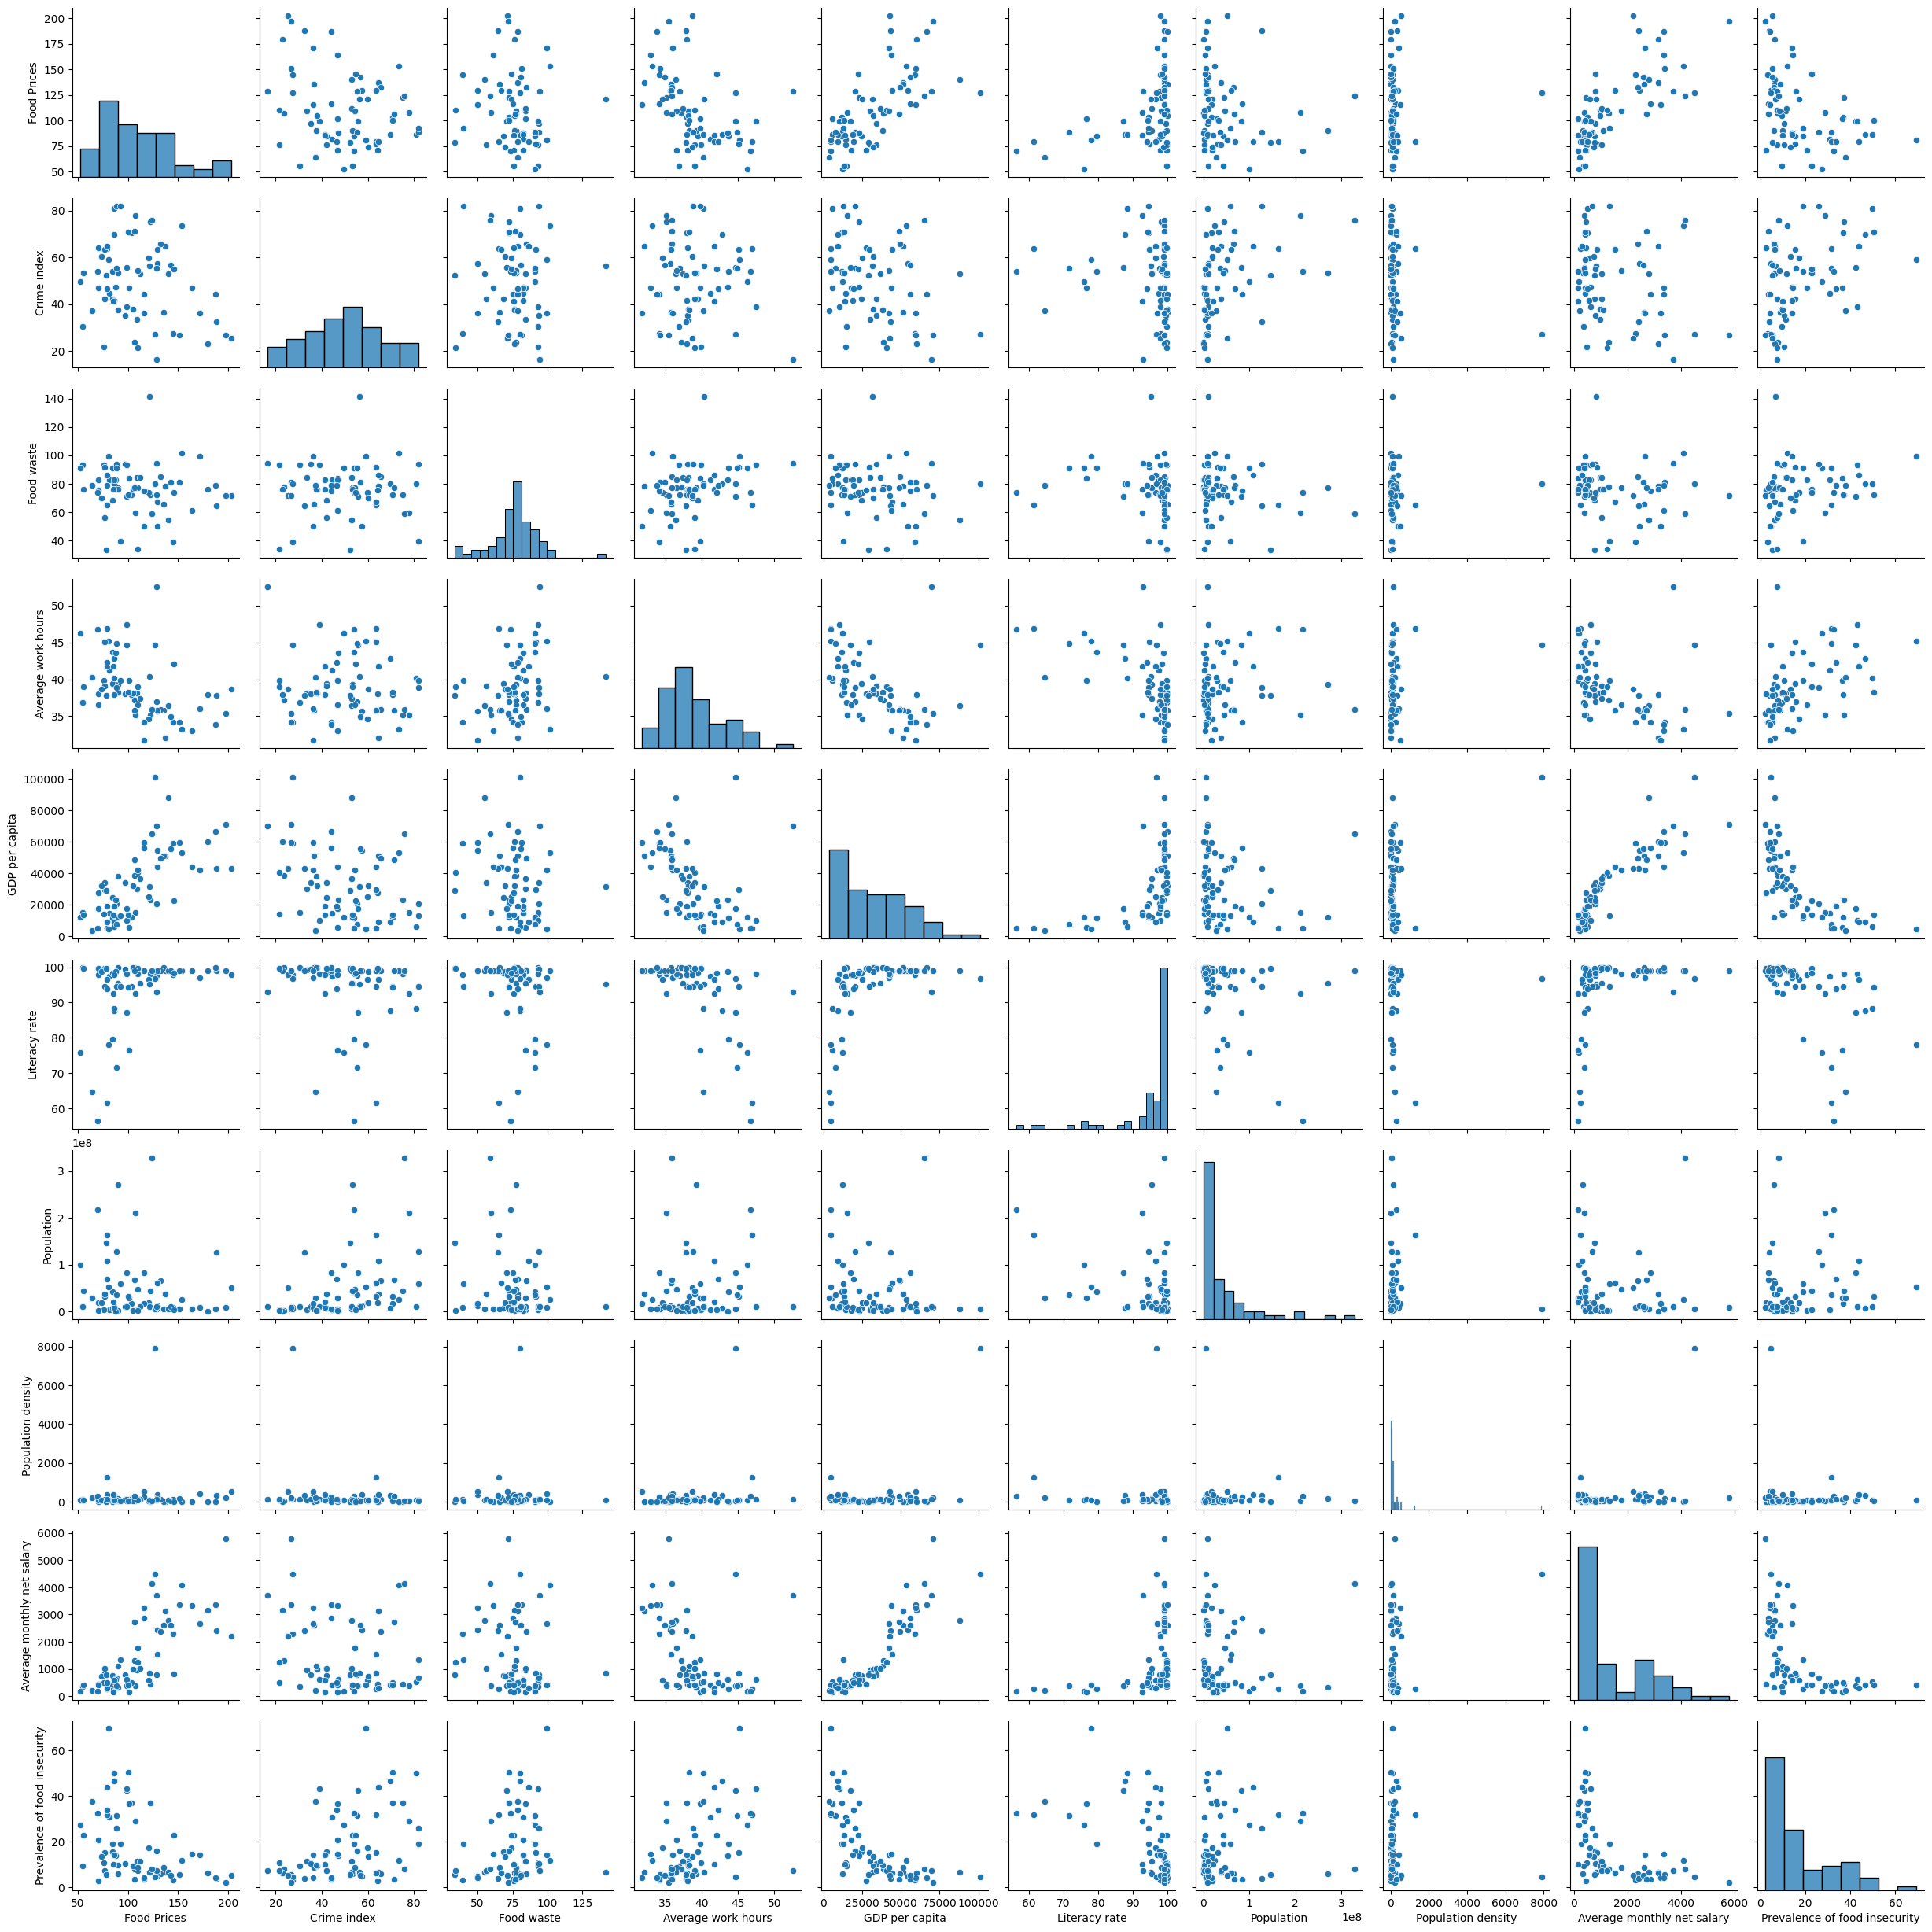

In [70]:
sns.pairplot(df)

In [62]:
def normalise_z(_df):
    dfout = _df.copy()
    dfout = (_df - _df.mean()) / _df.std()
    return dfout

def normalise_minmax(_df):
    dfout = (_df - _df.min()) / (_df.max() - _df.min())
    return dfout

def get_features_targets(_df, feature_names, target_names):
    return _df[feature_names], _df[target_names]

def prepare_feature(_feature):
    # get number of columns
    cols = len(_feature.columns)
    
    # convert the data frame to a numpy array and change it into a column vectors
    # shape the feature columns
    feature = _feature.to_numpy().reshape(-1, cols)
    rows = feature.shape[0] # get number of rows
    
    # create our ones
    ones = np.ones((rows, 1))
    
    return np.concatenate((ones, feature), axis=1)

def prepare_target(_target):
    # convert the data frame to a numpy array and change it into column vectors
    cols = len(_target.columns)
    target = _target.to_numpy().reshape(-1, cols)
    return target

def poly_features(_df, colname, colname_transformed, degree=2):
    col = _df[colname]
    _df[colname_transformed] = np.power(col, degree)
    return _df

def lg_features(_df, colname, colname_transformed):
    col = _df[colname]
    _df[colname_transformed] = np.log10(col)
    return _df

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    np.random.seed(random_state)
    n = len(df_feature)
    
    test_num = int(n * (test_size))
    
    test_idx = np.random.choice(n, test_num, replace=False)
    train_idx = [i for i in range(n) if i not in test_idx]
    
    df_feature_test = df_feature.iloc[test_idx]
    df_feature_train = df_feature.iloc[train_idx]
    df_target_test = df_target.iloc[test_idx]
    df_target_train = df_target.drop(test_idx)
    return df_feature_train, df_feature_test, df_target_train, df_target_test

def calc_linear(X, beta):
    return np.matmul(X, beta)

def predict(_feature, beta):
    X = prepare_feature(normalise_z(_feature))
    return calc_linear(X, beta)

In [63]:
# Linear Regression class
class LinearRegression:
    def __init__(self):
        self.beta = None
        self.J_storage = None
    
    def compute_cost(self, X, y, beta=None):
        """Compute the cost function.

        Args:
            X (np.ndarray): 2D Numpy feature array.
            y (np.ndarray): 2D Numpy target array.
            beta (numpy.ndarray, optional): 2D Numpy parameter array. Defaults to None.
            store(bool): Boolean on whether to store the J value.

        Returns:
            np.ndarray: J storage.
        """
        m = X.shape[0]
        if beta is None:
            beta = self.beta
        error = calc_linear(X, beta) - y
        error_sq = error.T @ error
        J = (1/(2*m)) * error_sq
        J = J[0][0]
        return J
    
    def predict(self, _feature):
        """Predicts target values.

        Args:
            _feature (np.ndarray): 2D Numpy feature array.

        Returns:
            np.ndarray: Predicted values.
        """
        return predict(_feature, self.beta)

    def fit(self, X, y, iterations, alpha):
        """Fits linear regression model using gradient descent.

        Args:
            X (np.ndarray): 2D Numpy feature array.
            y (np.ndarray): 2D Numpy target array.
            iterations (int): Number of iterations.
            alpha (float): Learning rate.

        Returns:
            (np.ndarray, np.ndarray): Tuple of beta and J.
        """
        n, p = X.shape
        self.J_storage = np.zeros((iterations, 1))
        # Generate random beta weights
        beta = np.random.randn(p, 1) / np.sqrt(n)
        #beta = np.zeros((p, 1))
        for i in range(iterations):
            y_hat = calc_linear(X, beta)
            deriv = np.matmul(X.T, y_hat - y)
            beta -= alpha * (1/n) * deriv
            self.J_storage[i] = self.compute_cost(X, y, beta=beta)
        self.beta = beta
        return beta, self.J_storage

In [64]:
# Evaluator class
class Evaluator:
    def __init__(self, target, prediction):
        self.target = target
        self.prediction = prediction

    def mean_absolute_error(self):
        """Evaluates the Mean Absolute Error.

        Returns:
            float: MAE.
        """
        n = self.target.shape[0]
        error = abs(self.target - self.prediction)
        return np.sum(error) / n
    
    def r2_score(self):
        """Evaluates the R2 score.

        Returns:
            float: R2 score.
        """
        SS_res = np.sum((self.prediction - self.target) ** 2)
        SS_tot = np.sum((self.target - self.target.mean()) ** 2)
        return 1 - (SS_res / SS_tot)

    def adjusted_r2_score(self):
        """Evaluates the Adjusted R2 score.

        Returns:
            float: Adjusted R2 score.
        """
        r2 = self.r2_score()
        N, p = self.target.shape
        adj_r2 = 1 - (1 - r2) * (N - 1) / (N - p - 1)
        return adj_r2

    def evaluate(self):
        """Evaluates the model.

        Returns:
            object: Object containing "mae", "r2" and "ar2" results.
        """
        r2 = self.r2_score()[0]
        ar2 = self.adjusted_r2_score()[0]
        mae = self.mean_absolute_error()[0]
        return { "mae": mae, "r2": r2, "ar2": ar2 }
    
    def __str__(self):
        evals = self.evaluate()
        return f"mae: {evals.mae} | r2: {evals.r2} | ar2: {evals.ar2}"

Index(['Country', 'Food Prices', 'Crime index', 'Food waste',
       'Average work hours', 'GDP per capita', 'Literacy rate', 'Population',
       'Population density', 'Average monthly net salary',
       'Prevalence of food insecurity'],
      dtype='object')
{'mae': 0.7022674215914458, 'r2': -1.0915409134557574, 'ar2': -1.2016220141639553}


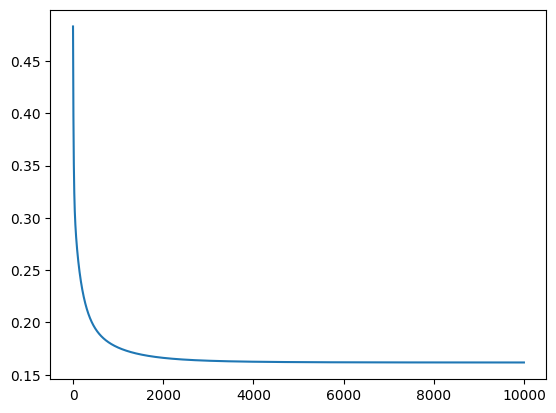

In [67]:
# As most of the code will be duplicated below, the comments here are to demonstrate what we are doing
# Predictor vars
columns = ['Food Prices', 'Crime index', 'Food waste',
       'Average work hours', 'GDP per capita', 'Literacy rate', 'Population',
       'Population density', "Average monthly net salary"]

print(df.columns)

# Getting the features and target from the data frame
df_features, df_target = get_features_targets(df, columns, ["Prevalence of food insecurity"])

# Normalising features and target
df_features = normalise_z(df_features)
df_target = normalise_z(df_target)

# Splitting the data sets for training and testing
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# Prepare the features and target
feature = prepare_feature(df_features_train)
target = prepare_target(df_target_train)

# Instantiate LinearRegression helper class
model = LinearRegression()
iterations = 10000
alpha = 0.01

# Fit a linear regression line
model.fit(feature, target, iterations, alpha)

# Predict using the model on testing features
predicted = model.predict(df_features_test)

plt.plot(model.J_storage)
score = Evaluator(df_target_test, predicted).evaluate()
print(str(score))

Index(['Country', 'Food Prices', 'Crime index', 'Food waste',
       'Average work hours', 'GDP per capita', 'Literacy rate', 'Population',
       'Population density', 'Average monthly net salary',
       'Prevalence of food insecurity', 'lit * pop', 'lg(l*p)', 'lg(gdp)'],
      dtype='object')


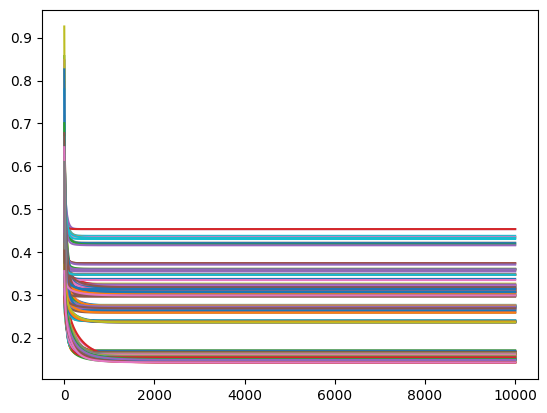

In [93]:
columns = ['Food Prices', 'Crime index', 'Food waste',
       'Average work hours', 'GDP per capita', 'Literacy rate', 'Population',
       'Population density', 'Average monthly net salary']

df_new = df.copy()
#df_new["Food insecure population"] = df_new["Prevalence of food insecurity"].multiply(df_new["Population"])

df_new["lit * pop"] = df_new["Literacy rate"] * df_new["Population"]
df_new = lg_features(df_new, "lit * pop", "lg(l*p)")

#df_new = poly_features(df_new, "GDP per capita", "gdp2", 2)
df_new = lg_features(df_new, "GDP per capita", "lg(gdp)")

print(df_new.columns)

columns_new = ['Food Prices', 'Crime index', 'Food waste', 'Average work hours',
       'Population density', 'Average monthly net salary',
       'lg(l*p)', 'lg(gdp)']

models = []
idx = 0

import itertools
# Iterating from combination of 2 vars to all
for L in range(2, len(columns_new) + 1):
       for subset in itertools.combinations(columns_new, L):
              _ss = np.array(subset)
              transform = ["GDP per capita"]

              df_features, df_target = get_features_targets(df_new, _ss, ["Prevalence of food insecurity"])

              df_features = normalise_z(df_features)
              df_target = normalise_z(df_target)

              df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=1000, test_size=0.3)

              feature = prepare_feature(df_features_train)
              target = prepare_target(df_target_train)

              model = LinearRegression()
              iterations = 10000
              alpha = 0.01

              model.fit(feature, target, iterations, alpha)
              #print(f"beta: {model.beta}")
              predicted = model.predict(df_features_test)

              plt.plot(model.J_storage)

              score = Evaluator(df_target_test, predicted).evaluate()
              # Store the models' betas and scores for comparison later
              models.append({ "score": score, "set": _ss, "id": idx, "beta": model.beta })
              idx += 1

In [94]:
max(models, key=lambda s: s["score"]["ar2"])

{'score': {'mae': 0.4385574168746453,
  'r2': 0.6897682795787843,
  'ar2': 0.6734402942934572},
 'set': array(['Food Prices', 'Crime index', 'Average work hours', 'lg(l*p)',
        'lg(gdp)'], dtype='<U18'),
 'id': 169,
 'beta': array([[-0.03618712],
        [ 0.15904125],
        [ 0.19298047],
        [ 0.21006177],
        [-0.12828843],
        [-0.75841651]])}

In [90]:
print(df.columns)

Index(['Country', 'Food Prices', 'Crime index', 'Food waste',
       'Average work hours', 'GDP per capita', 'Literacy rate', 'Population',
       'Population density', 'Average monthly net salary',
       'Prevalence of food insecurity'],
      dtype='object')


{'mae': 0.4385574168746453, 'r2': 0.6897682795787843, 'ar2': 0.6734402942934572}


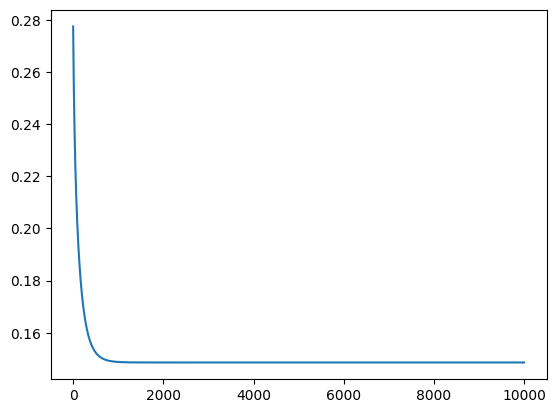

In [97]:
# As most of the code will be duplicated below, the comments here are to demonstrate what we are doing
# Predictor vars
columns = ['Food Prices', 'Crime index', 'Average work hours', 'lg(l*p)', 'lg(gdp)']

df_new = df.copy()

df_new["lit * pop"] = df_new["Literacy rate"] * df_new["Population"]
df_new = lg_features(df_new, "lit * pop", "lg(l*p)")

#df_new = poly_features(df_new, "GDP per capita", "gdp2", 2)
df_new = lg_features(df_new, "GDP per capita", "lg(gdp)")

# Getting the features and target from the data frame
df_features, df_target = get_features_targets(df_new, columns, ["Prevalence of food insecurity"])

# Normalising features and target
df_features = normalise_z(df_features)
df_target = normalise_z(df_target)

# Splitting the data sets for training and testing
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=1000, test_size=0.3)

# Prepare the features and target
feature = prepare_feature(df_features_train)
target = prepare_target(df_target_train)

# Instantiate LinearRegression helper class
model = LinearRegression()
iterations = 10000
alpha = 0.01

# Fit a linear regression line
model.fit(feature, target, iterations, alpha)

# Predict using the model on testing features
predicted = model.predict(df_features_test)

plt.plot(model.J_storage)
score = Evaluator(df_target_test, predicted).evaluate()
print(str(score))

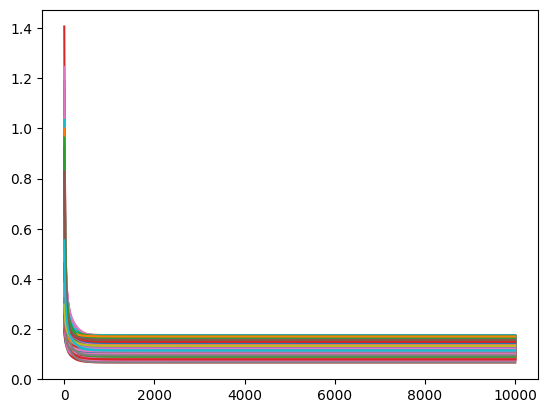

In [99]:
# As most of the code will be duplicated below, the comments here are to demonstrate what we are doing
# Predictor vars
columns = ['Food Prices', 'Crime index', 'Average work hours', 'lg(l*p)', 'lg(gdp)']

df_new = df.copy()

df_new["lit * pop"] = df_new["Literacy rate"] * df_new["Population"]
df_new = lg_features(df_new, "lit * pop", "lg(l*p)")

#df_new = poly_features(df_new, "GDP per capita", "gdp2", 2)
df_new = lg_features(df_new, "GDP per capita", "lg(gdp)")

# Getting the features and target from the data frame
df_features, df_target = get_features_targets(df_new, columns, ["Prevalence of food insecurity"])

# Normalising features and target
df_features = normalise_z(df_features)
df_target = normalise_z(df_target)

models = []

for i in range(0, 1000):
    # Splitting the data sets for training and testing
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=i, test_size=0.3)

    # Prepare the features and target
    feature = prepare_feature(df_features_train)
    target = prepare_target(df_target_train)

    # Instantiate LinearRegression helper class
    model = LinearRegression()
    iterations = 10000
    alpha = 0.01

    # Fit a linear regression line
    model.fit(feature, target, iterations, alpha)

    # Predict using the model on testing features
    predicted = model.predict(df_features_test)

    plt.plot(model.J_storage)
    score = Evaluator(df_target_test, predicted).evaluate()
    models.append({ "score": score, "set": _ss, "id": i, "beta": model.beta })

In [100]:
max(models, key=lambda s: s["score"]["ar2"])

{'score': {'mae': 0.25854918167653423,
  'r2': 0.8890290458905572,
  'ar2': 0.8831884693584813},
 'set': array(['Food Prices', 'Crime index', 'Food waste', 'Average work hours',
        'Population density', 'Average monthly net salary', 'lg(l*p)',
        'lg(gdp)'], dtype='<U26'),
 'id': 644,
 'beta': array([[-0.02176934],
        [ 0.20088275],
        [ 0.32031083],
        [ 0.18805523],
        [-0.13419196],
        [-0.78542999]])}

In [79]:
import statsmodels.api as sm
dfin = df.copy()
dfin["lit * pop"] = dfin["Literacy rate"] * dfin["Population"]
dfin = lg_features(dfin, "lit * pop", "lg(l*p)")

dfin = poly_features(dfin, "GDP per capita", "gdp2", 2)
dfin = lg_features(dfin, "gdp2", "lg(gdp2)")

dfin = normalise_z(dfin.iloc[:, 1:])
#display(dfin.iloc[:, [1,3,9,11,13]])

X = dfin.iloc[:, :].values
Y = dfin.iloc[:, -1].values
X = np.append(arr = np.ones((70, 1)).astype("float64"), values = X, axis = 1)
# X = np.append(arr = np.ones((59, 1)).astype('float64'), values = X, axis = 1)

X_Optimal = X[:, [5, 6, 8, 9]]
X_Optimal = np.array(X_Optimal, dtype=float)
regressor_OLS = sm.OLS(endog = Y, exog = X_Optimal).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              323.3
Date:                Thu, 24 Nov 2022   Prob (F-statistic):                    1.43e-42
Time:                        21:47:28   Log-Likelihood:                          7.0547
No. Observations:                  70   AIC:                                     -6.109
Df Residuals:                      66   BIC:                                      2.885
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9330      0.072     13.018      0.000       0.790       1.076
x2             0.2921      0.033      8.765      0.000       0.226       0.359
x3            -0.1162      0.031     -3.780      0.000      -0.178      -0.055
x4            -0.1254      0.064     -1.970      0.053      -0.253       0.002
==============================================================================
Omnibus:                       24.333   Durbin-Watson:                   2.652
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.235
Skew:                          -1.333   Prob(JB):                     4.98e-09
Kurtosis:                       5.450   Cond. No.                         5.31
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""